# MT(マハラノビス田口)法
* 参考文献
    * よくわかるMTシステム（田原希志臣、日本規格協会）
    * 入門MTシステム（立林和夫、日科技連）
    * 実験計画法とタグチメソッド（菅民郎、オーム社）

 <br>

## MTシステムとは
* 判断の基準点を一つだけ定め、多くの情報(**多変量**)を総合した判断尺度を用いて、基準点からの離れ具合によって定量的に判断する手法
    * MT法における判断尺度：マハラノビス距離
    * 判断するための正常な集団：単位空間（MT法では、正常な集団によって構成されたマハラノビス距離空間)


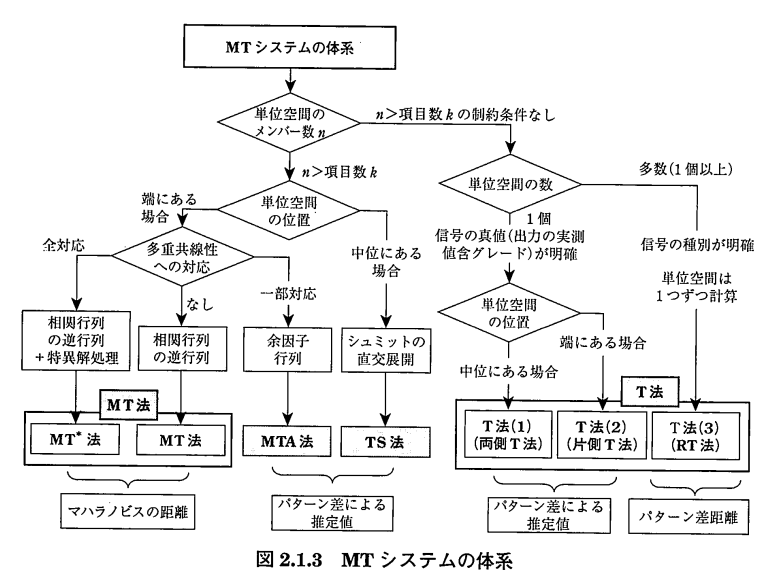

In [ ]:
from PIL import Image
filename = "./mt_system.png"
im = Image.open(filename)
im

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## * MT法とは
* 多変量をマハラノビス距離に変換することで単一指標を作り、その指標に変換した値が閾値を超えたかどうかで、２値分類（例えば異常・正常）を行う手法
* マハラノビス距離を用いることで、変数間の相関具合を考慮できる
* ただし、相関ありすぎると多重共線性が発生するなど、利用できるデータに制限がある

## * MT法にてマハラノビス距離を求める手順

1. パターンを表現する変数を決める
2. サンプルを沢山集める
3. 単位空間を構成するサンプルを選択し、単位空間を定義する
    * 例えば、企業の業績診断をする場合、単位空間を決める企業をどう決めるか？　他に比べて業績が良い企業は、他には無い特徴を持っている企業と考えられるため、**業績が平凡**な企業を選んだ方が良い。平凡な企業は、良くも悪くも際立った特徴がない企業と言えるので、業績が良い企業や悪い企業よりもずっと安定した単位空間となることが期待できる。
4. 判断対象サンプルのマハラノビス距離を求める
    * 判別の閾値の決め方：(損失関数を用いるか、ドメインナレッジを用いて)判別を誤ることによって発生する損失が最小となるように閾値を決める。

## * MT法の制約
1. **`欠損値`**があると計算できない
    * 欠損レコードを捨てるか、穴埋め必要
2. **`サンプル数 < 変数数`**では計算できない
    * 変数の数を減らすか、マルチMT法で対応必要
3. 標準偏差が**`ゼロ(定数)`**の変数があると計算できない
    * 定数の変数は捨てる
4. 変数間に**`多重共線性`**があると計算出来ない
    * 変数間に強い順・逆相関があると逆行列が求められなくなる
    * 相関が強い変数を捨てるか、マルチMT法を用いる

## * MT法データ処理手順
1. 単位空間の定義に用いるサンプルと変数データを集める
2. データの欠損値を補完する
3. 変数ごとに正規化(平均0, 分散1)する
    * 変数間の単位を揃えるため正規化が必要。忘れると、単位大きい変数の影響が大きくなる
4. 変数間の相関を求めて、相関行列を作成する
5. 変数間の相関状況を確認する
    * 強相関がある変数については、削除するかMMT法を利用する
6. 相関行列の逆行列を求める
7. サンプルのマハラノビス距離を求め、閾値を決める
    * 相関行列の代わりに、分散共分散行列を用いても良いが、相関行列の方が、多重共線性のリスク確認ができるので、相関行列推奨
8. 評価対象のマハラノビス距離を求める
9. 閾値を超えているか判別する


## * MT法による異常値判別のコード例

* 変数：ph、水温、降水量、化学的酸素要求量（COD）
* 上記変数のうち、正常なレコードを抽出してマハラノビス距離を算出する
* 算出した正常レコード集団のマハラノビス距離の最大値を超えたレコードを異常値と識別する
* ダミーデータを利用


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### 1. ダミーデータ作成
* 変数名：ph, 数値範囲：4~10, 桁数：小数点1桁
* 変数名：water_temp, 数値範囲：10~60, 桁数：小数点0桁
* 変数名：rain, 数値範囲：0~100, 桁数：小数点0桁
* 変数名：cod, 数値範囲：0~10, 桁数：小数点1桁

In [2]:
np.random.seed(42)

# 変数生成
ph = np.round(np.random.uniform(4, 10, 2000), 1)          # ph: 4~10, 小数点1桁
water_temp = np.round(np.random.uniform(10, 60, 2000), 0) # water_temp: 10~60, 小数点0桁
rain = np.round(np.random.uniform(0, 100, 2000), 0)       # rain: 0~100, 小数点0桁
cod = np.round(np.random.uniform(0, 10, 2000), 1)         # COD: 0~10, 小数点1桁

data_df = pd.DataFrame({
    'ph': ph,
    'water_temp': water_temp,
    'rain': rain,
    'cod': cod
})

data_df.head()

,ph,water_temp,rain,cod
0,6.2,23.0,57.0,6.5
1,9.7,22.0,81.0,1.7
2,8.4,55.0,76.0,8.7
3,7.6,22.0,15.0,6.1
4,4.9,24.0,15.0,1.6


In [3]:
data_df.describe()

,ph,water_temp,rain,cod
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,6.991400,34.823500,49.649500,4.877700
std,1.754273,14.430193,28.806815,2.873216
min,4.000000,10.000000,0.000000,0.000000
25%,5.400000,23.000000,25.000000,2.400000
50%,7.000000,35.000000,49.000000,4.800000
75%,8.500000,47.000000,74.000000,7.400000
max,10.000000,60.000000,100.000000,10.000000


### 2. 欠損値チェック

In [4]:
missing_values = data_df.isnull().sum()

print("欠損値の合計:", missing_values.sum())
print("各列ごとの欠損値:\n", missing_values)

欠損値の合計: 0
各列ごとの欠損値:
 ph            0
water_temp    0
rain          0
cod           0
dtype: int64


### 3. 最適なサンプルデータ(正常データ)の抽出
* ph:6~10,かつ water_temp:35以下,かつ rain:25以下,かつ COD:5以下を正常データと仮定する

In [24]:
sampled_data = data_df[
    (data_df['ph'] >= 6) &
    (data_df['ph'] <= 10) &
    (data_df['water_temp'] <= 35) &
    (data_df['rain'] <= 25) &
    (data_df['cod'] <= 5)
]

In [25]:
sampled_data.describe()

,ph,water_temp,rain,cod
count,98.000000,98.000000,98.000000,98.000000
mean,7.875510,23.255102,13.142857,2.423469
std,1.174827,7.757020,7.539586,1.486420
min,6.000000,10.000000,0.000000,0.000000
25%,6.900000,16.250000,7.000000,1.000000
50%,7.800000,23.000000,14.000000,2.350000
75%,8.750000,30.000000,19.000000,3.700000
max,10.000000,35.000000,25.000000,4.900000


### 4, 5. 相関行列の作成と相関状況の確認

In [26]:
x = sampled_data.values

# 標準化
mean_val = np.mean(x, axis=0)
std_val = np.std(x, axis=0) # 分散は不偏分散ではないので、n割の分散使う
x_std = (x - mean_val) / std_val

# 相関算出
corr_matrix = np.corrcoef(x_std, rowvar=False)

# 相関確認
corr_matrix

array([[ 1.        ,  0.05883896, -0.10551369, -0.0182046 ],
       [ 0.05883896,  1.        , -0.07096248,  0.0099365 ],
       [-0.10551369, -0.07096248,  1.        ,  0.01818768],
       [-0.0182046 ,  0.0099365 ,  0.01818768,  1.        ]])

* 変数が多いときは、ヒートマップなどで確認するか、指定した相関以上の変数を自動削除する？

### 6. 逆行列を求める


In [27]:
inv_corr_matrix = np.linalg.inv(corr_matrix)
inv_corr_matrix

array([[ 1.01426875, -0.05254088,  0.10297955,  0.01711347],
       [-0.05254088,  1.00791025,  0.06620147, -0.01217564],
       [ 0.10297955,  0.06620147,  1.01587748, -0.01725957],
       [ 0.01711347, -0.01217564, -0.01725957,  1.00074644]])

### 7. サンプルデータのマハラノビス距離を求める
* MT法でのマハラノビス距離は、変数の数で割って正規化することで、単位円を作る

In [28]:
# スケーリング因子
k = x_std.shape[1]

print(f"変量数：{k}")

変量数：4


In [29]:
# マハラノビス距離の算出
mahala_dists = []
for i in range(len(x_std)):
    # レコード抽出
    row = x_std[i, :]
    # マハラノビス距離の算出
    D2 = (1 / k) * np.dot(np.dot(row, inv_corr_matrix), row.T)
    mahala_dists.append(np.sqrt(D2))

# dfに保存
sampled_data['mahala_dist'] = mahala_dists

<ipython-input-29-5527d4e8e470>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['mahala_dist'] = mahala_dists


In [30]:
sampled_data.describe()

,ph,water_temp,rain,cod,mahala_dist
count,98.000000,98.000000,98.000000,98.000000,98.000000
mean,7.875510,23.255102,13.142857,2.423469,0.968966
std,1.174827,7.757020,7.539586,1.486420,0.248467
min,6.000000,10.000000,0.000000,0.000000,0.248208
25%,6.900000,16.250000,7.000000,1.000000,0.840678
50%,7.800000,23.000000,14.000000,2.350000,0.974949
75%,8.750000,30.000000,19.000000,3.700000,1.138268
max,10.000000,35.000000,25.000000,4.900000,1.442866


* マハラノビス距離の平均が1に近いので、正しくマハラノビス空間が作られている

* 異常判別の閾値は、mahara_distのmax値より2に設定する

### 8. 異常値判別
* 以下の各レコードのマハラノビス距離を求めて、閾値を超えているかどうかで異常値か判断する
    1. ph:2, water_temp:30, rain:0, cod:2 - 強酸性(異常と思われるレコード)
    2. ph:7, water_temp:55, rain:0, cod:1 - 高水温(異常と思われるレコード)
    3. ph:8, water_temp:24, rain:80, cod:1 - 高水量(異常と思われるレコード)
    4. ph:7, water_temp:55, rain:0, cod:10 - 高cod(異常と思われるレコード)
    5. ph:7, water_temp:25, rain:0, cod:1 - 正常と思われるレコード

* 注意
    * 判別対象のレコードを標準化するときは、サンプルデータの平均と分散を使う
    * 判別対象のレコードのマハラノビス距離を求めるときは、サンプルデータの逆行列を用いる

In [31]:
# 判別対象レコードのデータフレーム作成
new_records = pd.DataFrame({
    'ph': [2, 7, 8, 7, 7],
    'water_temp': [30, 55, 24, 55, 25],
    'rain': [0, 0, 80, 0, 0],
    'cod': [2, 1, 1, 10, 1]
})

# 標準化
target_rec_std = (new_records.values - mean_val) / std_val

# マハラノビス距離を計算
new_distances = []
for i in range(len(target_rec_std)):
    row = target_rec_std[i, :]
    D2 = (1 / k) * np.dot(np.dot(row, inv_corr_matrix), row.T)
    new_distances.append(np.sqrt(D2))

# 閾値設定
max_mahalanobis_distance = 2

# 新しいレコードの異常判定
new_records['mahala_dist'] = new_distances
new_records['Is_Anomalous'] = new_records['mahala_dist'] > max_mahalanobis_distance

# 結果の表示
new_records

,ph,water_temp,rain,cod,mahala_dist,Is_Anomalous
0,2,30,0,2,2.815663,True
1,7,55,0,1,2.311498,True
2,8,24,80,1,4.534744,True
3,7,55,0,10,3.402787,True
4,7,25,0,1,1.103859,False


* 最後のレコード以外は、異常値と判断された

## 散布図にて結果確認
* マハラノビス距離の分布をプロットして確認する

In [ ]:
# import plotly.express as px
# import plotly.io as pio
# import plotly.graph_objects as go
# pio.renderers.default = 'iframe' # or 'colab' or 'iframe' or 'iframe_connected' or 'sphinx_gallery'

In [32]:
sampled_data["Is_Anomalous"] = "Sample"
all_data = pd.concat([sampled_data, new_records], ignore_index=True)

<ipython-input-32-2aef7dcafe9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data["Is_Anomalous"] = "Sample"


In [33]:
all_data['plt_index'] = 0
all_data

,ph,water_temp,rain,cod,mahala_dist,Is_Anomalous,plt_index
0,8.2,34.0,6.0,2.5,0.819407,Sample,0
1,6.0,35.0,6.0,4.6,1.442866,Sample,0
2,6.8,29.0,4.0,0.2,1.160078,Sample,0
3,9.4,14.0,14.0,2.7,0.923759,Sample,0
4,7.1,31.0,0.0,2.8,1.086881,Sample,0
...,...,...,...,...,...,...,...
98,2.0,30.0,0.0,2.0,2.815663,True,0
99,7.0,55.0,0.0,1.0,2.311498,True,0
100,8.0,24.0,80.0,1.0,4.534744,True,0
101,7.0,55.0,0.0,10.0,3.402787,True,0


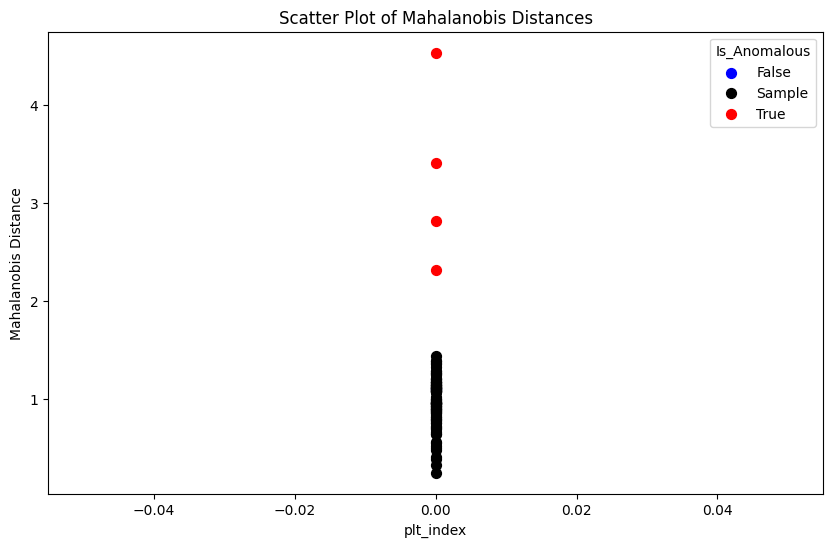

In [34]:
import matplotlib.pyplot as plt

all_data['Is_Anomalous'] = all_data['Is_Anomalous'].astype(str)

groups = all_data.groupby('Is_Anomalous')

color_map = {'Sample': 'black', 'False': 'blue', 'True': 'red'}

plt.figure(figsize=(10, 6))
for group_name, group_data in groups:
    plt.scatter(
        group_data['plt_index'],
        group_data['mahala_dist'],
        label=group_name,
        color=color_map[group_name],
        s=50
    )

plt.title('Scatter Plot of Mahalanobis Distances')
plt.xlabel('plt_index')
plt.ylabel('Mahalanobis Distance')

plt.legend(title='Is_Anomalous')

plt.show()

* マハラノビス距離が2より大きいレコードを異常値として判別している

## 主成分分析で4変数を２成分に変換して異常値の分布をプロット
* 正規化後のデータを使って主成分分析にかけること

In [35]:
from sklearn.decomposition import PCA

In [36]:
sed_sample = pd.DataFrame(x_std, columns=['ph', 'water_temp', 'rain', 'cod'])
sed_target = pd.DataFrame(target_rec_std, columns=['ph', 'water_temp', 'rain', 'cod'])
sed_target['Is_Anomalous'] = new_records['Is_Anomalous']
sed_sample['Is_Anomalous'] = 'Sample'
all_scaled_data = pd.concat([sed_sample, sed_target], ignore_index=True)


In [37]:
# 主成分分析 (PCA) の実行
pca = PCA(n_components=2)  # 2次元に変換
pca_transformed = pca.fit_transform(all_scaled_data.drop(columns=['Is_Anomalous']))

# 主成分をデータフレームに追加
all_scaled_data['PCA1'] = pca_transformed[:, 0]
all_scaled_data['PCA2'] = pca_transformed[:, 1]

In [38]:
all_scaled_data

,ph,water_temp,rain,cod,Is_Anomalous,PCA1,PCA2
0,0.277622,1.392305,-0.952251,0.051751,Sample,-1.321208,0.314317
1,-1.604622,1.521884,-0.952251,1.471806,Sample,-1.820823,1.753194
2,-0.920169,0.744414,-1.218882,-1.503547,Sample,-1.059450,-0.899681
3,1.304301,-1.199260,0.114270,0.186995,Sample,0.597940,-0.950789
4,-0.663500,1.003571,-1.752143,0.254616,Sample,-2.018288,0.104730
...,...,...,...,...,...,...,...
98,-5.026883,0.873992,-1.752143,-0.286357,True,-2.147133,0.716630
99,-0.749056,4.113450,-1.752143,-0.962573,True,-2.843675,1.201694
100,0.106509,0.096523,8.913073,-0.962573,True,8.280534,3.014886
101,-0.749056,4.113450,-1.752143,5.123374,True,-4.237009,5.118081


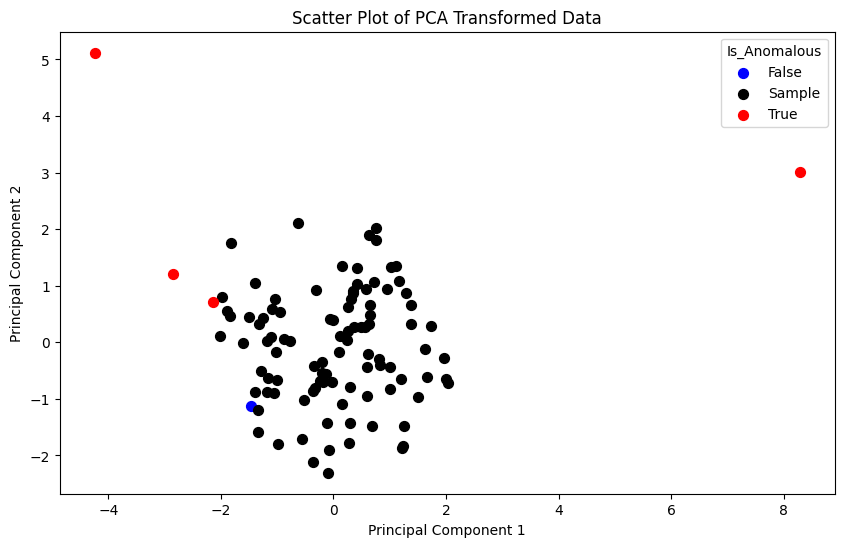

In [39]:
import matplotlib.pyplot as plt

all_scaled_data['Is_Anomalous'] = all_scaled_data['Is_Anomalous'].astype(str)

groups = all_scaled_data.groupby('Is_Anomalous')

color_map = {'Sample': 'black', 'False': 'blue', 'True': 'red'}

plt.figure(figsize=(10, 6))
for group_name, group_data in groups:
    plt.scatter(
        group_data['PCA1'],
        group_data['PCA2'],
        label=group_name,
        color=color_map.get(group_name, 'gray'),
        s=50
    )

plt.title('Scatter Plot of PCA Transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.legend(title='Is_Anomalous')

plt.show()

* 1点、正常集団の分布に近い異常値判定を受けたレコードが存在する。
    * 異常値の閾値を厳しく設定すると上記のようになるので、閾値の設定をゆるくするか厳しくするか検討必要

## 変数選択
* 4変数のうち、どの変数が異常値検知に役立ち、どれが役立っていないかをSN比より識別する
* 直交表を用いて、各水準（使う、使わない）ごとのマハラノビス距離を算出後、SN比を求めて、水準でのSN比の推移から各変数の有用性を判断する
* ※ 注意点：
    * 現状用意した手元のサンプルに対して有効で無くても、まだ見ぬサンプルに対しては有効の可能性があるので、計算コストなどの問題がない限りは、用意したすべての変数をそのまま用いていた方が良い。


### 手順
1. 各変数を直交表に割り付ける
    * 水準1：対象変数を使う、水準2：対象変数を使わない、として割付けを行う
2. 直交表の割付けに従って、複数の単位空間を定義する
    * 実験ごとに、水準1（対象となる変数）の変数を用いて、マハラノビス距離空間を作成する
3. それぞれの単位空間を用いて、異常サンプルのマハラノビス距離を求める
4. 得られたマハラノビス距離から各異常レコードのSN比を求める
5. 得られたSN比から、変数ごとの要因効果図を作成する



#### 1. 各変数を直交表に割り付ける

* 4変数なので、L8直交表を利用する
* 水準1：対象変数を使う
* 水準2：対象変数を使わない

<br>

| 項目組み合わせ | ph  | water_temp | rain | cod |
| -------------- | --- | ---------- | ---- | --- |
| No1            | 1   | 1          | 1    | 1   |
| No2            | 1   | 1          | 1    | 2   |
| No3            | 1   | 2          | 2    | 1   |
| No4            | 1   | 2          | 2    | 2   |
| No5            | 2   | 1          | 2    | 1   |
| No6            | 2   | 1          | 2    | 2   |
| No7            | 2   | 2          | 1    | 1   |
| No8            | 2   | 2          | 1    | 2   |


上記Noごとに、単位空間を作成することになるが、Noごとに値が1の変数のみ使う


In [40]:
ph = [1, 1, 1, 1, 2, 2, 2, 2]
water_temp = [1, 1, 2, 2, 1, 1, 2, 2]
rain = [1, 1, 2, 2, 2, 2, 1, 1]
cod = [1, 2, 1, 2, 1, 2, 1, 2]

oa_df = pd.DataFrame(
    {
    'ph': ph,
    'water_temp': water_temp,
    'rain': rain,
    'cod': cod
    },
    index= [x for x in range(1,9)]
)

oa_df

,ph,water_temp,rain,cod
1,1,1,1,1
2,1,1,1,2
3,1,2,2,1
4,1,2,2,2
5,2,1,2,1
6,2,1,2,2
7,2,2,1,1
8,2,2,1,2


#### 2. 直交表の割付けに従って、複数の単位空間を定義する

In [41]:
def make_mahala_space(data):
    '''
    引数のマハラノビス空間を作成して返す
    ・param data: dataframe マハラノビス空間を作成するデータセット
    ・return:
        ・data: 各レコードごとにマハラノビス距離の計算結果列が含まれるdataframe
        ・mean_val: 各列の平均値
        ・std_val: 各列の標準偏差
        ・inv_corr_matrix: 相関係数行列の逆行列
    '''
    x = data.values

    # 標準化
    mean_val = np.mean(x, axis=0)
    std_val = np.std(x, axis=0) # 分散は不偏分散ではないので、n割の分散使う
    x_std = (x - mean_val) / std_val

    if len(data.columns) > 1:
        # 相関算出
        corr_matrix = np.corrcoef(x_std, rowvar=False)

        # 逆行列算出
        inv_corr_matrix = np.linalg.inv(corr_matrix)

        # 因子数抽出
        k = x_std.shape[1]

        # マハラノビス距離の算出
        mahala_dists = []
        for i in range(len(x_std)):
            # レコード抽出
            row = x_std[i, :]
            # マハラノビス距離の算出
            D2 = (1 / k) * np.dot(np.dot(row, inv_corr_matrix), row.T)
            # mahala_dists.append(np.sqrt(D2))
            mahala_dists.append(D2) # 変数選択で使うマハラノビス距離は２乗のまま使う
    else:
        # 変数１つなので、行列使わない
        mahala_dists = []
        for i in range(len(x_std)):
            D2 = np.square((x_std[i] - mean_val) / std_val)
            # mahala_dists.append(np.sqrt(D2))
            mahala_dists.append(D2)

        inv_corr_matrix = None

    # dfに保存
    data['mahala_dist'] = mahala_dists

    return data, mean_val, std_val, inv_corr_matrix

In [42]:
ori_data = sampled_data.drop(columns=['mahala_dist', 'Is_Anomalous'])

# 実験ごとの対象列をセット
oa_df['target_cols'] = oa_df.apply(lambda row: [col for col in oa_df.columns if row[col] == 1], axis=1)
oa_df

,ph,water_temp,rain,cod,target_cols
1,1,1,1,1,"[ph, water_temp, rain, cod]"
2,1,1,1,2,"[ph, water_temp, rain]"
3,1,2,2,1,"[ph, cod]"
4,1,2,2,2,[ph]
5,2,1,2,1,"[water_temp, cod]"
6,2,1,2,2,[water_temp]
7,2,2,1,1,"[rain, cod]"
8,2,2,1,2,[rain]


In [43]:
# 実験ごとにマハラノビス単位空間作成
maha_list = []
for idx, cols in enumerate(oa_df['target_cols']):
    target_data = ori_data[cols].copy()
    add_data, mean_val, std_val, inv_corr_matrix = make_mahala_space(target_data)
    maha_dic = {
        'No': idx,
        'target_cols': cols,
        'data': add_data,
        'mean_val': mean_val,
        'std_val': std_val,
        'inv_corr_matrix': inv_corr_matrix
    }
    maha_list.append(maha_dic)

In [44]:
maha_list[0]

{'No': 0,
 'target_cols': ['ph', 'water_temp', 'rain', 'cod'],
 'data':        ph  water_temp  rain  cod  mahala_dist
 9     8.2        34.0   6.0  2.5     0.671428
 85    6.0        35.0   6.0  4.6     2.081863
 89    6.8        29.0   4.0  0.2     1.345780
 118   9.4        14.0  14.0  2.7     0.853332
 129   7.1        31.0   0.0  2.8     1.181311
 ...   ...         ...   ...  ...          ...
 1915  8.3        30.0   8.0  2.4     0.304316
 1938  7.0        19.0  24.0  3.6     0.803850
 1967  6.2        12.0   9.0  0.3     1.660871
 1983  6.9        21.0   4.0  2.2     0.638158
 1994  8.5        35.0   7.0  1.2     0.910462
 
 [98 rows x 5 columns],
 'mean_val': array([ 7.8755102 , 23.25510204, 13.14285714,  2.42346939]),
 'std_val': array([1.16881775, 7.71734228, 7.50102034, 1.47881648]),
 'inv_corr_matrix': array([[ 1.01426875, -0.05254088,  0.10297955,  0.01711347],
        [-0.05254088,  1.00791025,  0.06620147, -0.01217564],
        [ 0.10297955,  0.06620147,  1.01587748, -0.01

#### 3. それぞれの単位空間を用いて、異常サンプルのマハラノビス距離を求める

In [45]:
# 異常レコードのdfから、不要列削除
ab_df = new_records.drop(columns=['mahala_dist', 'Is_Anomalous'])

# 異常判定のレコードのみ対象
ab_df.drop(index=4, inplace=True)
ab_df

,ph,water_temp,rain,cod
0,2,30,0,2
1,7,55,0,1
2,8,24,80,1
3,7,55,0,10


In [46]:
def calc_ab_m_dist(ab_record, m_dict):
    '''
    ab_record: 異常判定のレコード
    m_dict: マハラノビス距離空間の辞書
    ・return:
        ・異常レコードのマハラノビス距離
    '''

    mean_val = m_dict['mean_val']
    std_val = m_dict['std_val']
    inv_corr_matrix = m_dict['inv_corr_matrix']

    # 標準化
    target_rec_std = (ab_record.values - mean_val) / std_val

    # マハラノビス距離を計算
    k = len(m_dict['target_cols'])
    if k > 1:
        D2 = (1 / k) * np.dot(np.dot(target_rec_std, inv_corr_matrix), target_rec_std.T)
    else:
        D2 = np.square((target_rec_std - mean_val) / std_val)[0]

    return D2 # 変数選択で使うマハラノビス距離は２乗値
    # return np.sqrt(D2)

In [47]:
# 異常レコードごとに、直行表8パターンのマハラノビス距離を算出する
df_list = []
for idx, ab_row in ab_df.iterrows():
    m_dixt_list = []
    for m_dict in maha_list:
         # 実験対象の変数取得
        cols = m_dict['target_cols']
        # 対象変数のレコード
        target_ab = ab_row[cols]

        # マハラノビス距離算出
        md = calc_ab_m_dist(target_ab, m_dict)
        m_dixt_list.append(md)

    df = pd.DataFrame({'ab_record_' + str(idx+1):m_dixt_list})
    df_list.append(df)

ab_m_dis_df = pd.concat(df_list, axis=1)
ab_m_dis_df

,ab_record_1,ab_record_2,ab_record_3,ab_record_4
0,7.927961,5.343021,20.563905,11.578963
1,10.529109,6.793634,27.003341,6.793634
2,12.706193,0.757193,0.467234,13.339583
3,121.856009,54.447876,44.181124,54.447876
4,0.425460,8.963736,0.468902,21.377418
5,8.410614,6.152099,9.005095,6.152099
6,1.567395,1.968252,40.354100,14.827658
7,3.943123,3.943123,0.317977,3.943123


### 4. 得られたマハラノビス距離から各異常レコードのSN比を求める

In [48]:
# 実験ごとのsn比算出
def calc_sn_ratio(row):
    sn = -10 * np.log10((1/row['ab_record_1'] + 1/row['ab_record_2'] + 1/row['ab_record_3'] + 1/row['ab_record_4']) / 4)
    return sn

ab_m_dis_df['sn_ratio'] = ab_m_dis_df.apply(calc_sn_ratio, axis=1)
ab_m_dis_df

,ab_record_1,ab_record_2,ab_record_3,ab_record_4,sn_ratio
0,7.927961,5.343021,20.563905,11.578963,9.505026
1,10.529109,6.793634,27.003341,6.793634,9.722423
2,12.706193,0.757193,0.467234,13.339583,0.440013
3,121.856009,54.447876,44.181124,54.447876,17.722875
4,0.425460,8.963736,0.468902,21.377418,-0.645870
5,8.410614,6.152099,9.005095,6.152099,8.577373
6,1.567395,1.968252,40.354100,14.827658,5.092382
7,3.943123,3.943123,0.317977,3.943123,0.103611


In [49]:
# SN比列抽出
sn_df = ab_m_dis_df['sn_ratio']

In [50]:
# SN比の差を算出する関数
def make_factor_df(sn_df):
    '''
    変数ごとに、使った場合と使わなかった場合のマハラノビス距離の平均を求めて返す
    '''

    ### phの要因効果
    # 使う場合：実験1,2,3,4
    D_u_ph = (sn_df[0]+sn_df[1]+sn_df[2]+sn_df[3]) / 4
    # 使わない場合：実験5,6,7,8
    D_n_ph = (sn_df[4]+sn_df[5]+sn_df[6]+sn_df[7]) / 4

    ### water_tempの要因効果
    # 使う場合：実験1,2,5,6
    D_u_wa = (sn_df[0]+sn_df[1]+sn_df[4]+sn_df[5]) / 4
    # 使わない場合：実験3,4,7,8
    D_n_wa = (sn_df[2]+sn_df[3]+sn_df[6]+sn_df[7]) / 4

    ### rainの要因効果
    # 使う場合：実験1,2,7,8
    D_u_r = (sn_df[0]+sn_df[1]+sn_df[6]+sn_df[7]) / 4
    # 使わない場合：実験3,4,5,6
    D_n_r = (sn_df[2]+sn_df[3]+sn_df[4]+sn_df[5]) / 4

    ### codの要因効果
    # 使う場合：実験1,3,5,7
    D_u_c = (sn_df[0]+sn_df[2]+sn_df[4]+sn_df[6]) / 4
    # 使わない場合：実験2,4,6,8
    D_n_c = (sn_df[1]+sn_df[3]+sn_df[5]+sn_df[7]) / 4

    # 結果df
    arrays = [
    ['ph', 'ph', 'water_temp', 'water_temp', 'rain', 'rain', 'cod', 'cod'],
    ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']
    ]
    columns = pd.MultiIndex.from_arrays(arrays, names=['factor', 'level'])
    sn_diff_df = pd.DataFrame(
        columns=columns,
        data=np.array([D_u_ph, D_n_ph, D_u_wa, D_n_wa, D_u_r, D_n_r, D_u_c, D_n_c]).reshape(1, 8))

    return sn_diff_df


# 要因効果図プロット用関数
def plot_factor_effect(plot_df):

    factors = plot_df.columns.get_level_values('factor').unique()
    num_factors = len(factors)

    # 横にグラフを並べる (1行に4つのサブプロット)
    fig, axes = plt.subplots(1, num_factors, figsize=(16, 4), sharey=True)  # 1行N列でサブプロット作成

    colors = ['b', 'g', 'r', 'orange']

    for i, factor in enumerate(factors):
        # "one" と "two" のデータを抽出
        y_values = plot_df[factor].values.flatten()
        x_values = [1, 2]  # one -> x=1, two -> x=2

        # サブプロットに描画
        ax = axes[i]
        ax.plot(
            x_values,
            y_values,
            marker='o',
            label=factor,
            color=colors[i]
        )
        ax.set_title(factor)  # 各サブプロットにタイトル
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['one', 'two'])
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--')  # 基準線
        if i == 0:
            ax.set_ylabel('SN ratio')  # 最初のグラフだけ yラベル

    # 全体の調整
    plt.suptitle('SN ratio change')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # タイトルとグラフの間隔を調整
    plt.show()

In [52]:
sn_diff_df = make_factor_df(sn_df)
sn_diff_df

factor        ph           water_temp              rain                 cod  \
level        one       two        one      two      one       two       one   
0       9.347584  3.281874   6.789738  5.83972  6.10586  6.523598  3.597888   

factor            
level        two  
0       9.031571

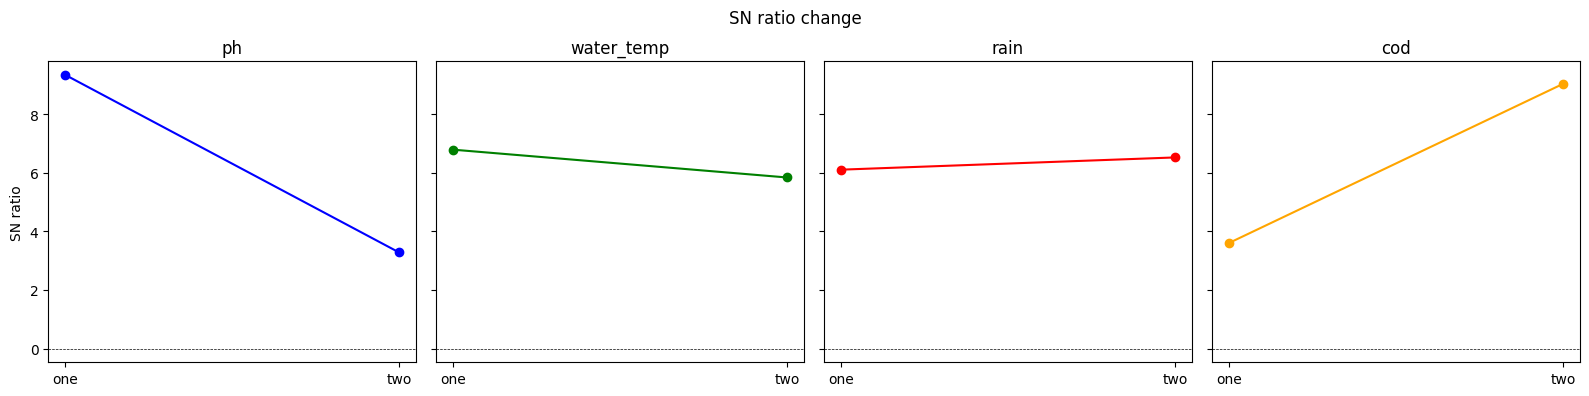

In [53]:
plot_factor_effect(sn_diff_df)

* グラフ見方
    * one(水準1)の方がSN ratioが高い指標は、判定に有用な変数
    * 逆に、two(水準2)の方が高い指標は、判定に役立っていない

<br>

* phが一番の判断指標になっている
* codが全く役に立っていない
* 対策：
    * 変数ごとに正常なデータ範囲を適切に設定する必要がある

## 異常値の原因診断

* 異常値判定を受けたレコードごとに、どの項目がその原因となっているか診断する

<br>

### 原因診断のための要因効果図の作成手順

1. 各変数を直交表に割り付ける
    * 水準1：対象変数を使う、水準2：対象変数を使わない、として割付けを行う
2. 直交表の割付けに従って、複数の単位空間を定義する
    * 実験ごとに、水準1（対象となる変数）の変数を用いて、マハラノビス距離空間を作成する
3. それぞれの単位空間を用いて、異常サンプルのマハラノビス距離を求める
4. 得られたマハラノビス距離から、変数ごとの要因効果図を作成する

* 備考
    * 上記手法は、「よくわかるMTシステム」より。
    * この本によると、原因診断ではSN比は不要

<br>

##### ※ 異常値診断に関しては、実際に行なっている例が数種の書籍にもなく、webでも全く検索に引っ掛からなかった為、あまり使われていないと思われる。実際、変数ごとに異常とみなす閾値を設定し、その設定値を超えた変数を表示さればいいので、あえて使う必要がない。また、以下で試したが、感度がイマイチだった。

### サンプルコードでの結果に対する原因診断の適用

* 異常値と判断された４レコードに対して、どの変数が原因となっているか原因診断を実施する。

### * 異常サンプル１- ph:2, water_temp:30, rain:0, cod:2 での原因診断
* phを異常値の原因として設定

#### 1. 各変数を直交表に割り付ける

* 変数選択で用いた直交表と同じものを使う


In [54]:
oa_df

,ph,water_temp,rain,cod,target_cols
1,1,1,1,1,"[ph, water_temp, rain, cod]"
2,1,1,1,2,"[ph, water_temp, rain]"
3,1,2,2,1,"[ph, cod]"
4,1,2,2,2,[ph]
5,2,1,2,1,"[water_temp, cod]"
6,2,1,2,2,[water_temp]
7,2,2,1,1,"[rain, cod]"
8,2,2,1,2,[rain]


#### 2. 直交表の割付けに従って、複数の単位空間を定義する
* やることは、変数選択での2と同じ

In [55]:
# 変数選択で作成した単位空間を使用する
maha_list[0]

{'No': 0,
 'target_cols': ['ph', 'water_temp', 'rain', 'cod'],
 'data':        ph  water_temp  rain  cod  mahala_dist
 9     8.2        34.0   6.0  2.5     0.671428
 85    6.0        35.0   6.0  4.6     2.081863
 89    6.8        29.0   4.0  0.2     1.345780
 118   9.4        14.0  14.0  2.7     0.853332
 129   7.1        31.0   0.0  2.8     1.181311
 ...   ...         ...   ...  ...          ...
 1915  8.3        30.0   8.0  2.4     0.304316
 1938  7.0        19.0  24.0  3.6     0.803850
 1967  6.2        12.0   9.0  0.3     1.660871
 1983  6.9        21.0   4.0  2.2     0.638158
 1994  8.5        35.0   7.0  1.2     0.910462
 
 [98 rows x 5 columns],
 'mean_val': array([ 7.8755102 , 23.25510204, 13.14285714,  2.42346939]),
 'std_val': array([1.16881775, 7.71734228, 7.50102034, 1.47881648]),
 'inv_corr_matrix': array([[ 1.01426875, -0.05254088,  0.10297955,  0.01711347],
        [-0.05254088,  1.00791025,  0.06620147, -0.01217564],
        [ 0.10297955,  0.06620147,  1.01587748, -0.01

#### 3. それぞれの単位空間を用いて、異常サンプルのマハラノビス距離を求める

In [56]:
ab_df

,ph,water_temp,rain,cod
0,2,30,0,2
1,7,55,0,1
2,8,24,80,1
3,7,55,0,10


In [57]:
# 異常サンプル１のインデックス
idx = 0

mdist_list = []
for m_dict in maha_list:
    # 異常サンプルのマハラノビス距離算出
    cols = m_dict['target_cols'] # 実験対象の変数取得

    target_ab = ab_df.loc[idx,cols].copy() # 異常サンプルのレコード

    # マハラノビス距離算出
    md = calc_ab_m_dist(target_ab, m_dict)
    mdist_list.append(md)


In [58]:
mdist_list

[7.9279605268626465,
 10.529109075372812,
 12.70619308893605,
 121.85600948096696,
 0.4254603032955423,
 8.410614096928075,
 1.5673949935522729,
 3.9431228955937003]

#### 4. 得られたマハラノビス距離から、変数ごとの要因効果図を作成する

In [59]:
def sn_r(value):
    return -10*np.log10(value)

def factor_analysis(mdistance_list):
    '''
    変数ごとに、使った場合と使わなかった場合のSN比の平均を求めて返す
    変数選択で作った関数とほぼ同じだが、ここでは、SN比を求めるコードが追加されている
    '''

    ### phの要因効果
    # 使う場合：実験1,2,3,4
    D_u_ph = (mdistance_list[0]+mdistance_list[1]+mdistance_list[2]+mdistance_list[3]) / 4
    # 使わない場合：実験5,6,7,8
    D_n_ph = (mdistance_list[4]+mdistance_list[5]+mdistance_list[6]+mdistance_list[7]) / 4
    # SN比
    D_u_ph = sn_r(1/D_u_ph)
    D_n_ph = sn_r(1/D_n_ph)

    ### water_tempの要因効果
    # 使う場合：実験1,2,5,6
    D_u_wa = (mdistance_list[0]+mdistance_list[1]+mdistance_list[4]+mdistance_list[5]) / 4
    # 使わない場合：実験3,4,7,8
    D_n_wa = (mdistance_list[2]+mdistance_list[3]+mdistance_list[6]+mdistance_list[7]) / 4

    D_u_wa = sn_r(1/D_u_wa)
    D_n_wa = sn_r(1/D_n_wa)

    ### rainの要因効果
    # 使う場合：実験1,2,7,8
    D_u_r = (mdistance_list[0]+mdistance_list[1]+mdistance_list[6]+mdistance_list[7]) / 4
    # 使わない場合：実験3,4,5,6
    D_n_r = (mdistance_list[2]+mdistance_list[3]+mdistance_list[4]+mdistance_list[5]) / 4

    D_u_r = sn_r(1/D_u_r)
    D_n_r = sn_r(1/D_n_r)

    ### codの要因効果
    # 使う場合：実験1,3,5,7
    D_u_c = (mdistance_list[0]+mdistance_list[2]+mdistance_list[4]+mdistance_list[6]) / 4
    # 使わない場合：実験2,4,6,8
    D_n_c = (mdistance_list[1]+mdistance_list[3]+mdistance_list[5]+mdistance_list[7]) / 4

    D_u_c = sn_r(1/D_u_c)
    D_n_c = sn_r(1/D_n_c)

    # 結果df
    arrays = [
    ['ph', 'ph', 'water_temp', 'water_temp', 'rain', 'rain', 'cod', 'cod'],
    ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']
    ]
    columns = pd.MultiIndex.from_arrays(arrays, names=['factor', 'level'])
    plot_df = pd.DataFrame(
        columns=columns,
        data=np.array([D_u_ph, D_n_ph, D_u_wa, D_n_wa, D_u_r, D_n_r, D_u_c, D_n_c]).reshape(1, 8))

    return plot_df

In [60]:
# 変数ごとの使った時、使わない時のSN比を算出
plot_df_1 = factor_analysis(mdist_list)
plot_df_1

factor         ph           water_temp                 rain             \
level         one       two        one        two       one        two   
0       15.826861  5.546888   8.339936  15.442936  7.775643  15.544839   

factor       cod             
level        one        two  
0       7.525672  15.585251

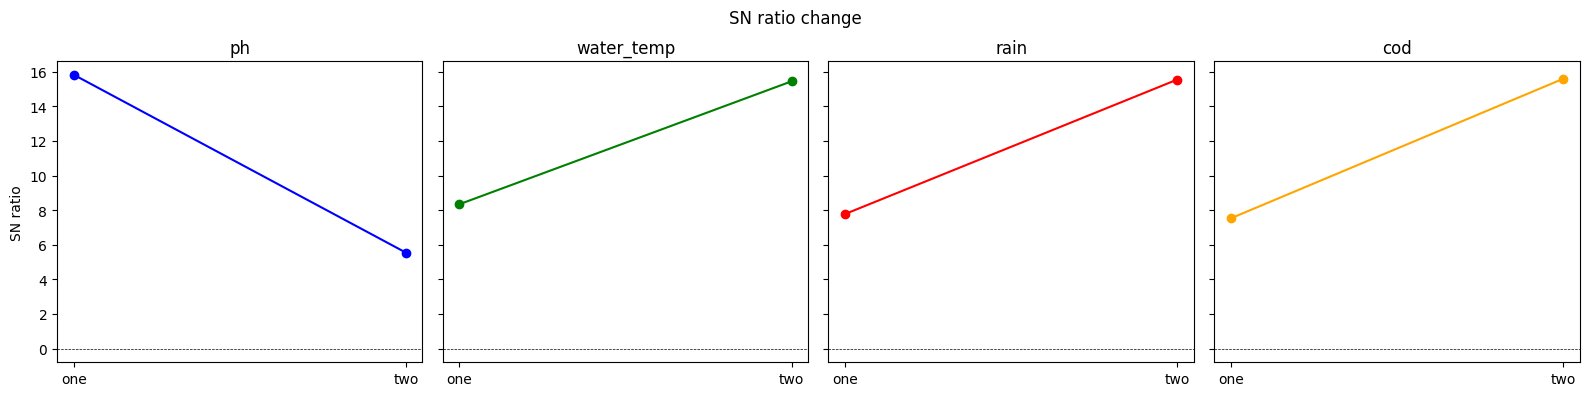

In [61]:
# 要因効果図
plot_factor_effect(plot_df_1)

* グラフの見方
    * one(水準1)の方が大きい場合、その変数がマハラノビス距離の増加に関与している。-> その変数が異常値の原因

* phのみ使っている時(one)の方が、使ってない時よりも値が大きくて幅も広いので、この異常値ではphが要因となっていることがわかる。

### * 異常サンプル2- ph:7, water_temp:55, rain:0, cod:1 での原因診断
* water_tempを異常値の原因として設定

In [62]:
# 異常サンプル2のインデックス
idx = 1

mdist_list = []
for m_dict in maha_list:
    # 異常サンプルのマハラノビス距離算出
    cols = m_dict['target_cols'] # 実験対象の変数取得

    target_ab = ab_df.loc[idx,cols].copy() # 異常サンプルのレコード

    # マハラノビス距離算出
    md = calc_ab_m_dist(target_ab, m_dict)
    mdist_list.append(md)


In [63]:
# 変数ごとの使った時、使わない時のマハラノビス距離を算出
plot_df_2 = factor_analysis(mdist_list)
plot_df_2

factor         ph           water_temp                 rain             \
level         one       two        one        two       one        two   
0       12.262242  7.207217   8.333462  11.840981  6.543698  12.450245   

factor       cod             
level        one        two  
0       6.292108  12.512532

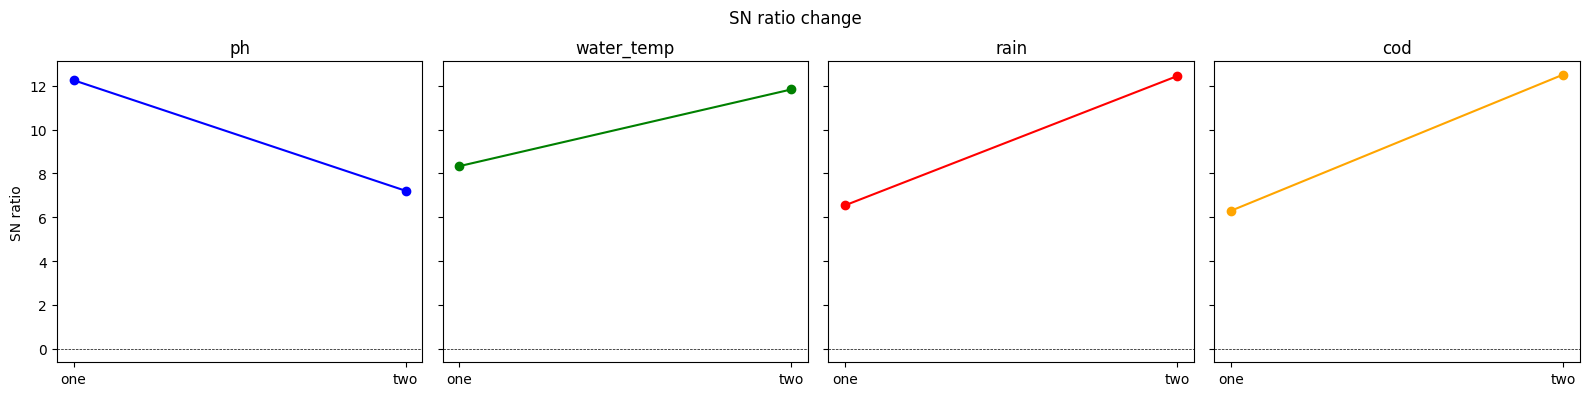

In [64]:
# 要因効果図
plot_factor_effect(plot_df_2)

* ※ water_tempを原因として設定したが、グラフからは読み取れない！！！
* phが原因として現れている

### * 異常サンプル3- ph:8, water_temp:24, rain:80, cod:1 での原因診断
* rainを異常値の原因として設定

In [65]:
# 異常サンプル3のインデックス
idx = 2

mdist_list = []
for m_dict in maha_list:
    # 異常サンプルのマハラノビス距離算出
    cols = m_dict['target_cols'] # 実験対象の変数取得

    target_ab = ab_df.loc[idx,cols].copy() # 異常サンプルのレコード

    # マハラノビス距離算出
    md = calc_ab_m_dist(target_ab, m_dict)
    mdist_list.append(md)


In [66]:
# 変数ごとの使った時、使わない時のマハラノビス距離を算出
plot_df_3 = factor_analysis(mdist_list)
plot_df_3

factor         ph            water_temp                  rain             \
level         one        two        one        two        one        two   
0       13.627444  10.981769   11.54129  13.289931  13.436022  11.313167   

factor        cod             
level         one        two  
0       11.893088  13.037765

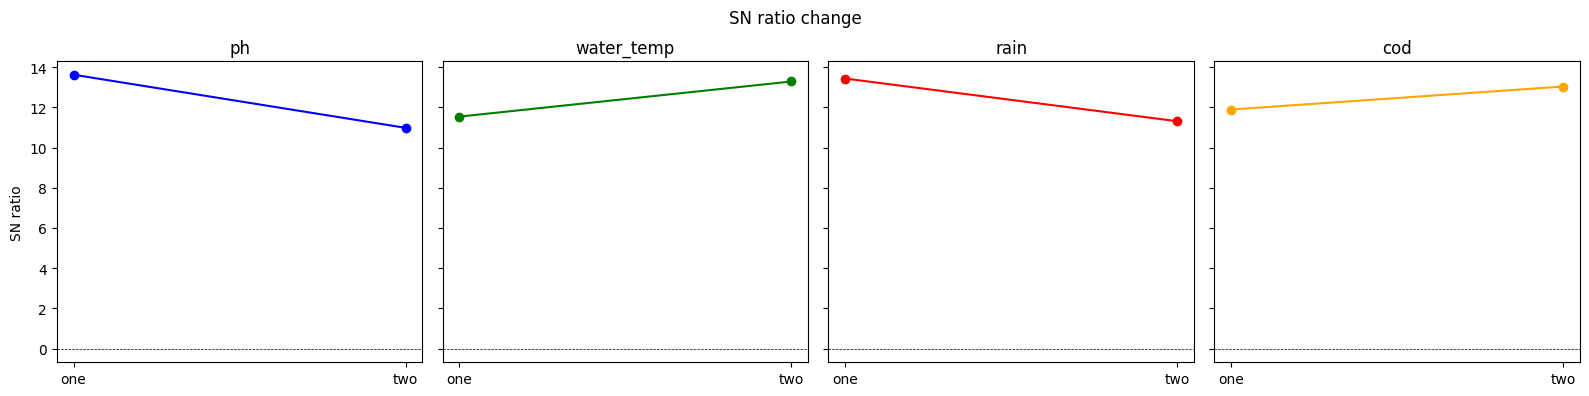

In [67]:
# 要因効果図
plot_factor_effect(plot_df_3)

* rainが異常値の原因として出ているが、phも原因として出ている。何故？

### * 異常サンプル4- ph:7, water_temp:55, rain:0, cod:10 での原因診断
* codを異常値の原因として設定

In [68]:
# 異常サンプル3のインデックス
idx = 3

mdist_list = []
for m_dict in maha_list:
    # 異常サンプルのマハラノビス距離算出
    cols = m_dict['target_cols'] # 実験対象の変数取得

    target_ab = ab_df.loc[idx,cols].copy() # 異常サンプルのレコード

    # マハラノビス距離算出
    md = calc_ab_m_dist(target_ab, m_dict)
    mdist_list.append(md)


In [69]:
# 変数ごとの使った時、使わない時のマハラノビス距離を算出
plot_df_4 = factor_analysis(mdist_list)
plot_df_4

factor        ph            water_temp                 rain             \
level        one        two        one        two       one        two   
0       13.33246  10.635238  10.597727  13.352484  9.678214  13.771103   

factor        cod             
level         one        two  
0       11.841491  12.512532

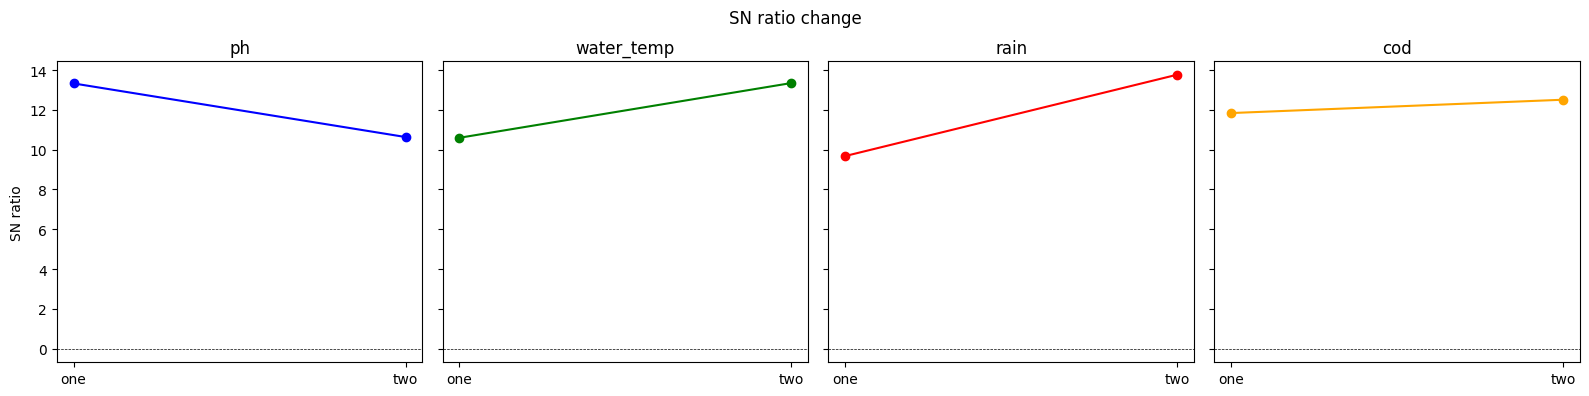

In [70]:
# 要因効果図
plot_factor_effect(plot_df_4)

* codを異常値の原因として設定したが、phの方が原因として大きく出ている。何故？